In [20]:
import numpy as np

In [21]:
import torch
import torch.nn as nn

In [22]:
load_model = True

# load data 

In [23]:
y_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/final_y.npy")
x_data = np.load(f"/sps/lsst/users/bbiswas/ICTS-School/final_x.npy")

In [24]:
x_data.shape

(3521, 7)

In [25]:
#y_data = np.load("/sps/lsst/users/bbiswas/ICTS-School/data/dv_output.npy")
#x_data = np.load("/sps/lsst/users/bbiswas/ICTS-School/data/training_params.npy")

In [26]:
DES_Y3_Cov = np.loadtxt("projects/des_y3/data/cov_shear_final.txt")
DES_Y3_data = np.loadtxt("projects/des_y3/data/Y3_shear_final.txt")

In [27]:
DES_Y3_Cov.shape

(810000, 3)

# Reshape cov matrix

In [28]:
output_dims=900
def get_full_cov(cov_file):
    print("Getting covariance...")
    full_cov = np.loadtxt(cov_file)
    cov = np.zeros((output_dims, output_dims))
    cov_scenario = full_cov.shape[1]

    for line in full_cov:
        i = int(line[0])
        j = int(line[1])

        if(cov_scenario==3):
            cov_ij = line[2]
        elif(cov_scenario==10):
            cov_g_block  = line[8]
            cov_ng_block = line[9]
            cov_ij = cov_g_block + cov_ng_block

        cov[i,j] = cov_ij
        cov[j,i] = cov_ij

    return cov

In [29]:
cov = get_full_cov("projects/des_y3/data/cov_shear_final.txt")

Getting covariance...


# extract shear-shear data

In [30]:
shear_shear_cov = cov[:400, :400]
shear_data_y3 = DES_Y3_data[:400, 1]
y_data_shear = y_data[:, :400]

# Compute Chi sq

In [31]:
def compute_chi_sq(delta, shear_shear_cov_inv):

    chi_sq=delta.T @ shear_shear_cov_inv @ delta
    
    return chi_sq

In [32]:
shear_shear_cov_inv = np.linalg.inv(shear_shear_cov)
chi_sq = []
for i in range(len(y_data_shear)):
    delta = y_data_shear[i] - shear_data_y3
    chi_sq.append(compute_chi_sq(delta, shear_shear_cov_inv))
    
chi_sq=np.array(chi_sq)

# plot and cut chi_sq

Text(0, 0.5, 'frequency')

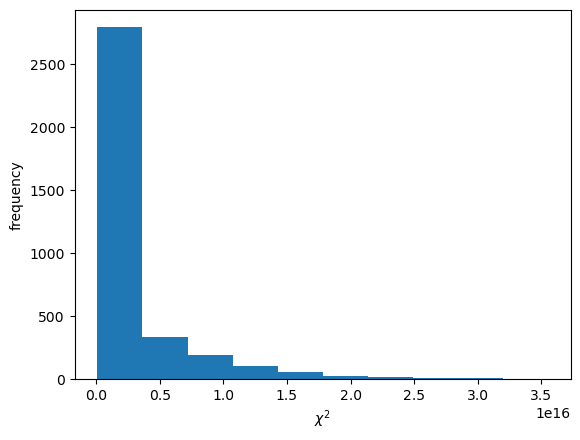

In [33]:
import matplotlib.pyplot as plt
plt.hist(chi_sq);
plt.xlabel("$\chi^2$")
plt.ylabel("frequency")

# Define NN module 

In [35]:
class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, output_dim, nodes):
        super(TwoHiddenLayerNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, 1024), 
                                   nn.ReLU(),
                                   nn.Linear(1024, output_dim), 
        )

    def forward(self, x):    
        return self.model(x)

In [36]:
model     = TwoHiddenLayerNN(7, 400, 4)

In [37]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
norm = np.load("/sps/lsst/users/bbiswas/ICTS-School/norms.npy", allow_pickle=True).item()

In [39]:
norm['x_mean']

array([2.35153000e+00, 9.68236253e-01, 7.14129226e+01, 5.07577486e-02,
       2.52832324e-01, 1.90734405e-01, 4.43486925e-01])

In [40]:
def gaussian_likelihood(y_actual, y_pred, cov, y_mean, y_std):
    
    y = y_actual*y_std + y_mean
    y_pred_unnorm = y_pred*y_std + y_mean
    
    dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=y,
        covariance_matrix=cov,
    )
    log_pxz = torch.mean(dist.log_prob(y_pred_unnorm))
    return -log_pxz

In [41]:
import random

In [42]:
loss2 = nn.MSELoss()

In [43]:
if load_model:
    em_model = TwoHiddenLayerNN(7, 400, 0)
    em_model.load_state_dict(torch.load("trainedmodel"))
    em_model.eval()

else:
    n_iters = 50000

    for iteration in range(n_iters):

        # create a batch of size 500
        batch_size = 500
        batch_index = random.sample(list(np.arange(len(x_data_norm))), batch_size)

        # predict y
        y_pred = model(torch.from_numpy(x_data_norm).to(torch.float32))

        # compute loss
        y_actual = torch.from_numpy(y_data_norm).to(torch.float32)
        #l = gaussian_likelihood(y_actual, y_pred, cov = torch.tensor(torch.ones(batch_size, 400, 400) * cov[:400, :400]), y_mean=torch.tensor(norm['y_mean']), y_std=torch.tensor(norm['y_std']))
        l = loss2(y_actual, y_pred)

        # gradient and step
        l.backward()
        optimizer.step()
        optimizer.zero_grad()    

        if (iteration % 10)==0:
            print("iteration: %d, \t loss: %.3e"%(iteration, l))
     
    torch.save(model.state_dict(), "trainedmodel")

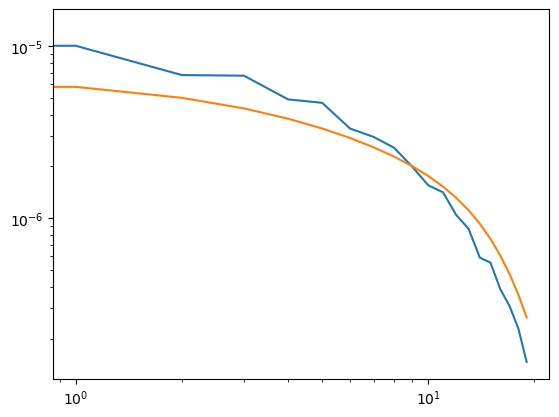

In [44]:
y_pred = model(torch.from_numpy(x_data[5]).to(torch.float32))

plt.plot((y_pred.detach().numpy()*norm['y_std'] + norm['y_mean'])[20:40])
plt.plot((y_data[5]*norm['y_std'] + norm['y_mean'])[20:40])
plt.xscale('log')
plt.yscale('log')

# Test chi sq

In [48]:
y_pred_normed = model(torch.from_numpy(x_data).to(torch.float32))
y_pred_actual = y_pred.detach().numpy()*norm['y_std'] + norm['y_mean']
y_data_actual = y_data*norm['y_std'] + norm['y_mean']


# for i in range(len(x_data)):
#     ()[:20])
# plt.plot(()[:20])

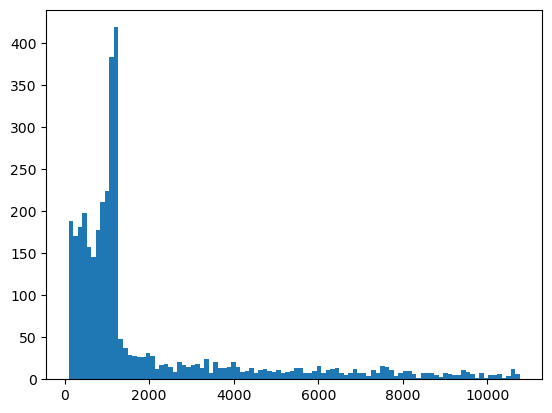

In [49]:
nn_chi_sqs = []
delta = y_data_actual - y_pred_actual

for i in range(len(delta)):
    nn_chi_sqs.append(compute_chi_sq(delta[i], shear_shear_cov_inv))
    
nn_chi_sqs = np.array(nn_chi_sqs)
plt.hist(nn_chi_sqs, bins=100);

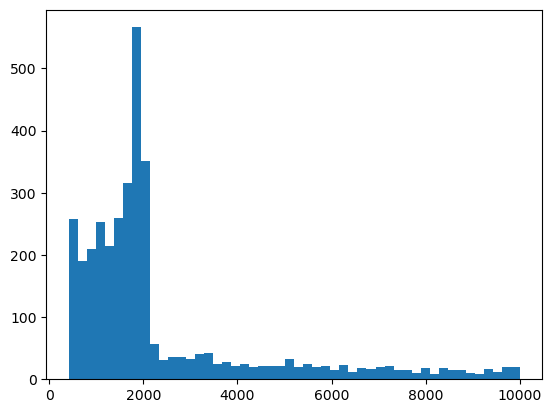

In [50]:
chi_sqs_y3 = []
delta_y3 = y_data_actual - shear_data_y3
for i in range(len(delta)):
    chi_sqs_y3.append(compute_chi_sq(delta_y3[i], shear_shear_cov_inv))
    
chi_sqs_y3 = np.array(chi_sqs_y3)
plt.hist(chi_sqs_y3, bins=50);

In [ ]:
plt.scatter(chi_sqs_y3, nn_chi_sqs)

plt.ylabel("$\chi^2_{NN}$")
plt.xlabel("$\chi^2_{DES}$")